In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Read data
df = pd.read_csv('compas-scores-two-years.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [5]:
#@title Preprocess the data

# Read data
df = pd.read_csv('compas-scores-two-years.csv')

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['days_b_screening_arrest'].notnull()]

# Rename recidivism column
df['recidivism_within_2_years'] = df['is_recid']

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

df = pd.get_dummies(df, columns=['sex', 'race', 'c_charge_degree'])
df['duration'] = df['end'] - df['start']

# Get list of all columns from the dataset we will use for model input or output.
input_features = ['sex_Male', 'age', 'c_charge_degree_F', 'race_African-American', 'race_Caucasian',
                  'race_Hispanic', 'race_Native American', 'race_Other', 'priors_count', 'juv_fel_count',
                  'juv_misd_count', 'juv_other_count', 'days_b_screening_arrest','c_days_from_compas', 'duration']

to_keep = input_features + ['recidivism_within_2_years', 'COMPASS_determination']

to_remove = [col for col in df.columns if col not in to_keep]
df = df.drop(columns=to_remove)

input_columns = df.columns.tolist()
labels = df['COMPASS_determination']
df.head(20)

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,recidivism_within_2_years,COMPASS_determination,sex_Male,race_African-American,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,duration
0,69,0,0,0,0,-1.0,1.0,0,0,1,0,0,0,0,1,1,327
1,34,0,0,0,0,-1.0,1.0,1,0,1,1,0,0,0,0,1,150
2,24,0,0,1,4,-1.0,1.0,1,0,1,1,0,0,0,0,1,63
5,44,0,0,0,0,0.0,0.0,0,0,1,0,0,0,0,1,0,852
6,41,0,0,0,14,-1.0,1.0,1,1,1,0,1,0,0,0,1,35
7,43,0,0,0,3,-1.0,1.0,0,0,1,0,0,0,0,1,1,265
8,39,0,0,0,0,-1.0,1.0,0,0,0,0,1,0,0,0,0,745
9,21,0,0,0,1,428.0,308.0,1,0,1,0,1,0,0,0,1,428
10,27,0,0,0,0,-1.0,1.0,0,0,1,0,1,0,0,0,1,857
11,23,0,0,0,3,0.0,0.0,1,1,1,1,0,0,0,0,0,124


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6907 entries, 0 to 7213
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        6907 non-null   int64  
 1   juv_fel_count              6907 non-null   int64  
 2   juv_misd_count             6907 non-null   int64  
 3   juv_other_count            6907 non-null   int64  
 4   priors_count               6907 non-null   int64  
 5   days_b_screening_arrest    6907 non-null   float64
 6   c_days_from_compas         6907 non-null   float64
 7   recidivism_within_2_years  6907 non-null   int64  
 8   COMPASS_determination      6907 non-null   int64  
 9   sex_Male                   6907 non-null   uint8  
 10  race_African-American      6907 non-null   uint8  
 11  race_Caucasian             6907 non-null   uint8  
 12  race_Hispanic              6907 non-null   uint8  
 13  race_Native American       6907 non-null   uint8

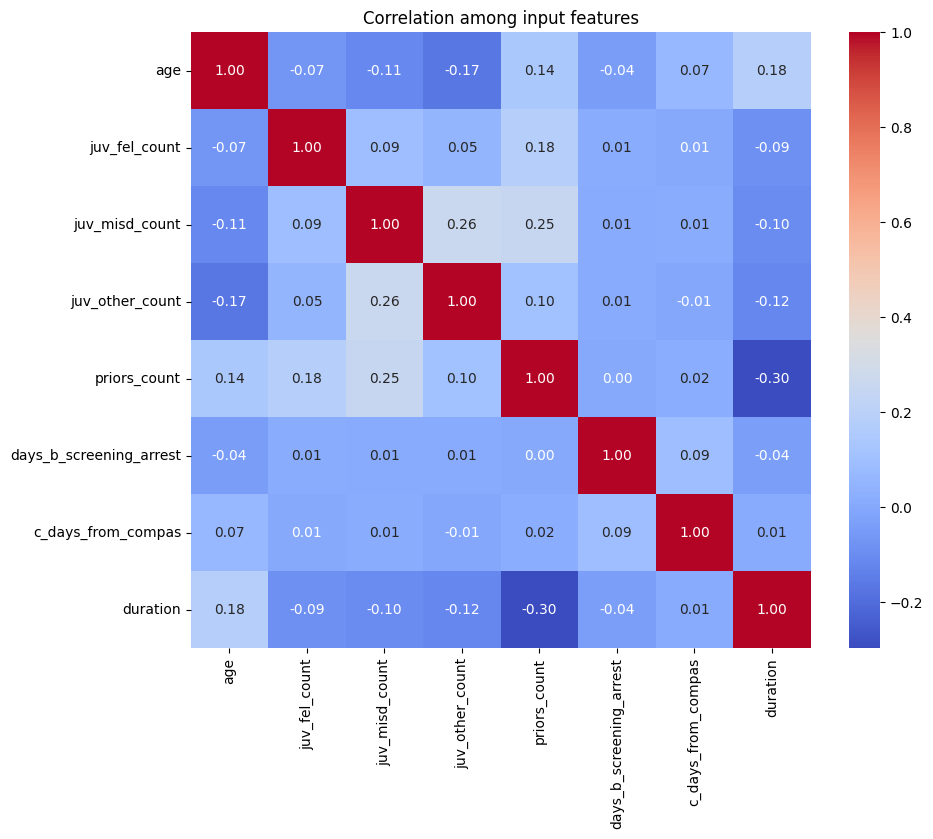

In [7]:
#@title Analyze data before training
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df = numeric_df.drop(columns = ['recidivism_within_2_years', 'COMPASS_determination'])
corr_matrix = numeric_df.corr()

# corrplot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation among input features')
plt.show()

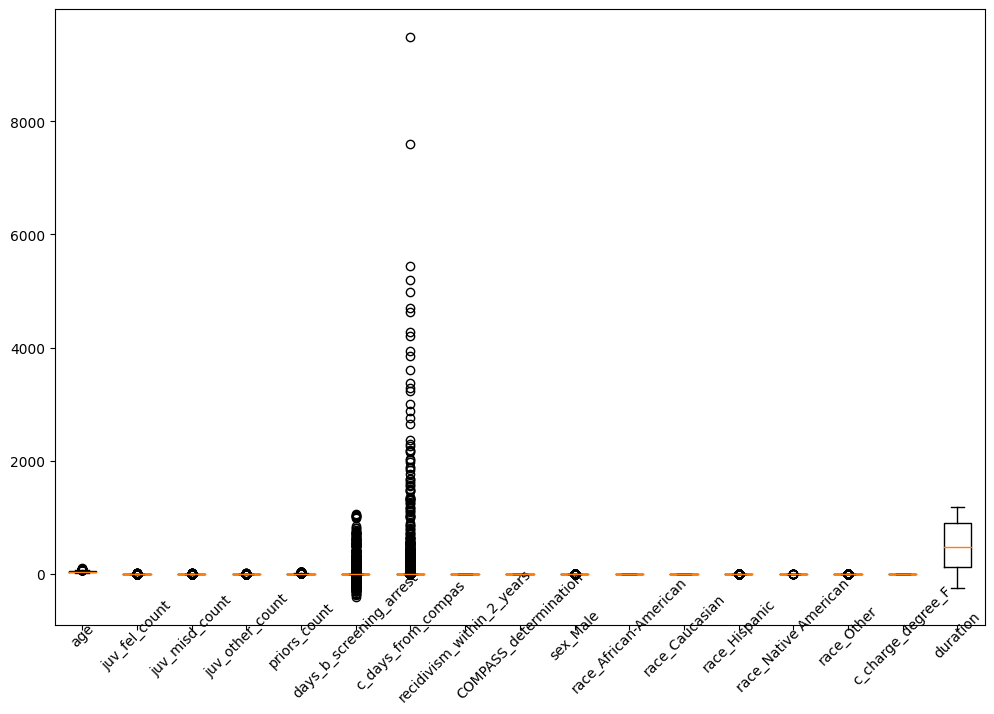

In [8]:
# Check for outliers
fig = plt.figure(figsize =(12, 8))
# Creating plot
plt.boxplot(df, labels=df.columns)
# Rotate x-axis labels by 45 degrees vertically
plt.xticks(rotation=45, va='center')
# show plot
plt.show()

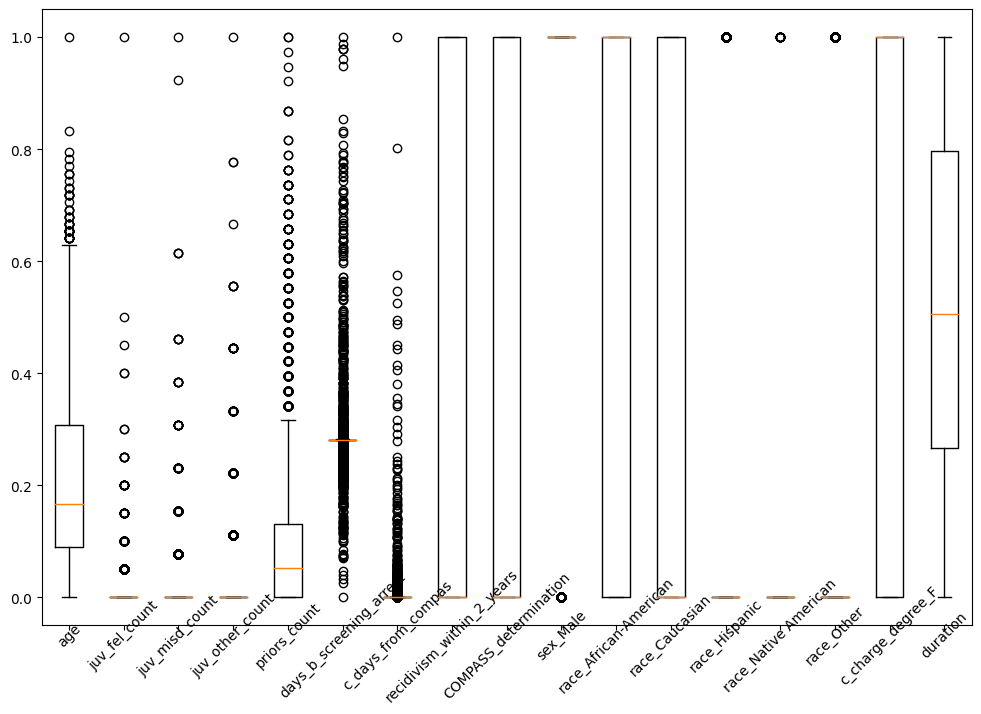

In [9]:
# Normalize the data
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Specify columns to normalize
columns_to_normalize = numeric_df.columns

# Fit and transform the specified columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Check for outliers in the normalized data
fig = plt.figure(figsize=(12, 8))
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, va='center')  # Ensure correct x-axis labels
plt.show()

0    3733
1    3174
Name: COMPASS_determination, dtype: int64


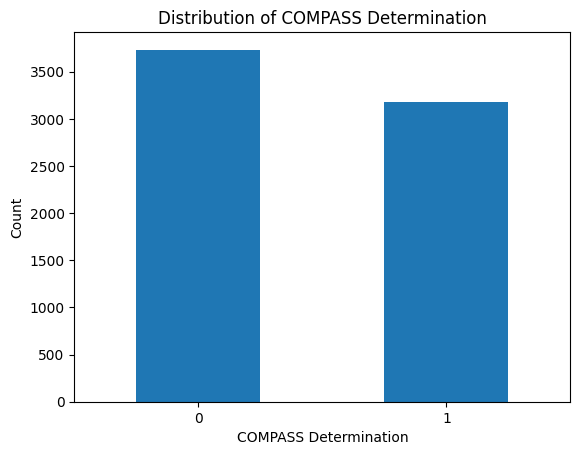

In [10]:
#is it balanced?
#target_var = df['recidivism_within_2_years'].value_counts()
target_var = df['COMPASS_determination'].value_counts()
print(target_var)

target_var.plot(kind='bar')
#plt.title('Distribution of True Recid')
plt.title('Distribution of COMPASS Determination')
plt.xlabel('COMPASS Determination')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

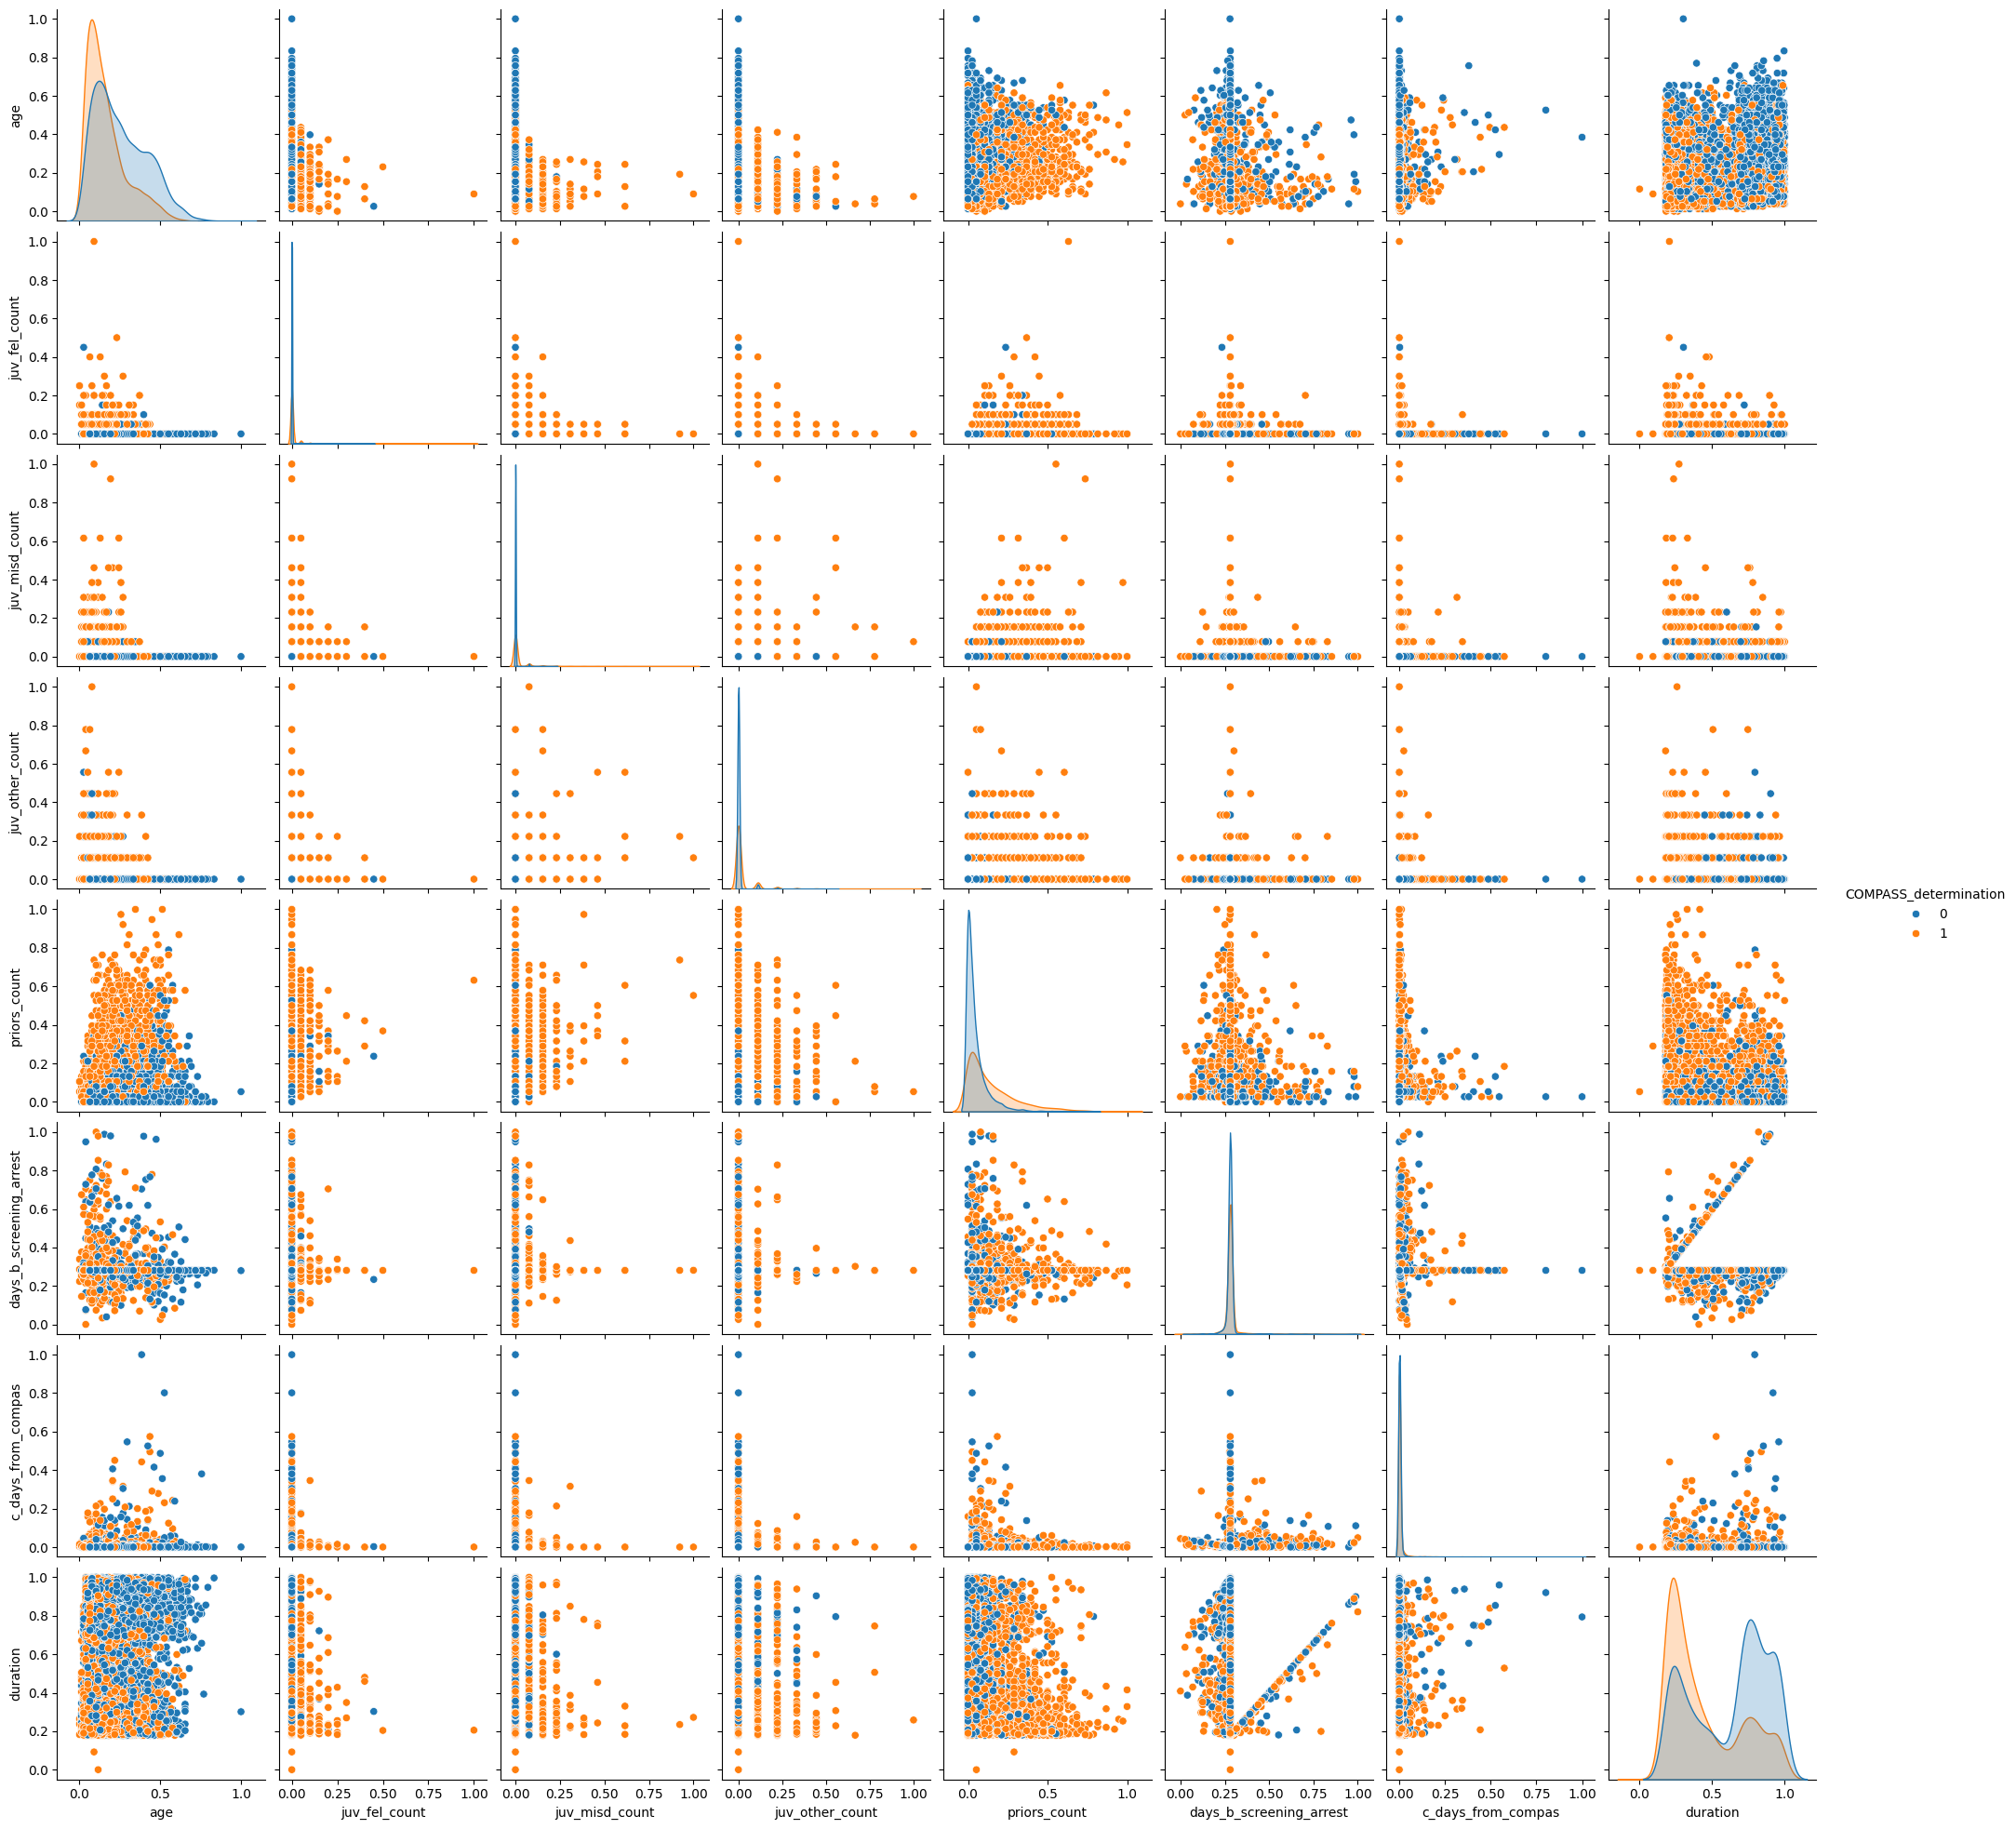

In [11]:
# Chek feature relationship
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df = numeric_df.drop(columns = ['recidivism_within_2_years']) # 'COMPASS_determination'

sns.pairplot(numeric_df, hue='COMPASS_determination')

In [12]:
#@title Create data structures needed for training and testing
# The training data doesn't contain the column we are predicting,
# 'COMPASS_determination', or the column we are using for evaluation of our
# trained model, 'recidivism_within_2_years'.
df_for_training = df.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
train_size = int(len(df_for_training) * 0.8)
train_data = df_for_training[:train_size]
train_labels = labels[:train_size]

test_data_with_labels = df[train_size:]
test_data = test_data_with_labels.drop(columns=['COMPASS_determination', 'recidivism_within_2_years'])
test_labels = labels[train_size:]

In [13]:
#@title Trial Models

# Define the DNN model
def create_dnn_model(input_size):
    model = Sequential()
    model.add(Dense(200, input_shape=(input_size,), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Add DNN model to the list of models
models = {
    "Logistic Regression": LogisticRegression(),
    "Kernel SVM": SVC(kernel='rbf', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "DNN": create_dnn_model(input_size=len(train_data.iloc[0]))
}

# Initialize lists to store evaluation metrics for each model
results = {
    "Model": [],
    "Accuracy": [],
    "F1 Score": [],
    "Precision": [],
    "Recall": []
}

# Perform K-fold cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    accuracy_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    roc_auc_list = []
    pr_auc_list = []

    for train_index, val_index in skf.split(train_data, train_labels):
        X_train_fold, X_val_fold = train_data.iloc[train_index], train_data.iloc[val_index]
        y_train_fold, y_val_fold = train_labels.iloc[train_index], train_labels.iloc[val_index]

        if model_name == "DNN":
            model.fit(X_train_fold.values, y_train_fold.values, epochs=16, batch_size=32, validation_data=(X_val_fold.values, y_val_fold.values), verbose=0)
            y_pred_proba = model.predict(test_data.values).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)
        else:
            model.fit(train_data, train_labels)
            y_pred_proba = model.predict_proba(test_data)[:, 1]
            y_pred = model.predict(test_data)

        # Calculate evaluation metrics
        # accuracy_list.append(accuracy_score(y_val_fold, y_pred))
        # f1_list.append(f1_score(y_val_fold, y_pred))
        # precision_list.append(precision_score(y_val_fold, y_pred))
        # recall_list.append(recall_score(y_val_fold, y_pred))
        accuracy_list.append(accuracy_score(test_labels, y_pred))
        f1_list.append(f1_score(test_labels, y_pred))
        precision_list.append(precision_score(test_labels, y_pred))
        recall_list.append(recall_score(test_labels, y_pred))

    # Calculate average evaluation metrics across all folds
    avg_accuracy = np.mean(accuracy_list)
    avg_f1_score = np.mean(f1_list)
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)

    # Print evaluation metrics
    print(f"{model_name} Evaluation Metrics:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")

    # Store results
    results["Model"].append(model_name)
    results["Accuracy"].append(avg_accuracy)
    results["F1 Score"].append(avg_f1_score)
    results["Precision"].append(avg_precision)
    results["Recall"].append(avg_recall)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results DataFrame
print("\nOverall Evaluation Results:")
print(results_df)


Training Logistic Regression...
Logistic Regression Evaluation Metrics:
Average Accuracy: 0.7294
Average F1 Score: 0.7055
Average Precision: 0.7191
Average Recall: 0.6924

Training Kernel SVM...
Kernel SVM Evaluation Metrics:
Average Accuracy: 0.7236
Average F1 Score: 0.6919
Average Precision: 0.7234
Average Recall: 0.6631

Training Decision Tree...
Decision Tree Evaluation Metrics:
Average Accuracy: 0.6735
Average F1 Score: 0.6534
Average Precision: 0.6496
Average Recall: 0.6572

Training Random Forest...
Random Forest Evaluation Metrics:
Average Accuracy: 0.7342
Average F1 Score: 0.7118
Average Precision: 0.7226
Average Recall: 0.7014

Training Gradient Boosting Classifier...
Gradient Boosting Classifier Evaluation Metrics:
Average Accuracy: 0.7546
Average F1 Score: 0.7253
Average Precision: 0.7618
Average Recall: 0.6921

Training XGBoost...
XGBoost Evaluation Metrics:
Average Accuracy: 0.7207
Average F1 Score: 0.6927
Average Precision: 0.7143
Average Recall: 0.6723

Training DNN...

*DNN has the best performance if we consider consider all the scores, especially F1 score and Recall.*

173/173 [==============================] - 0s 2ms/step


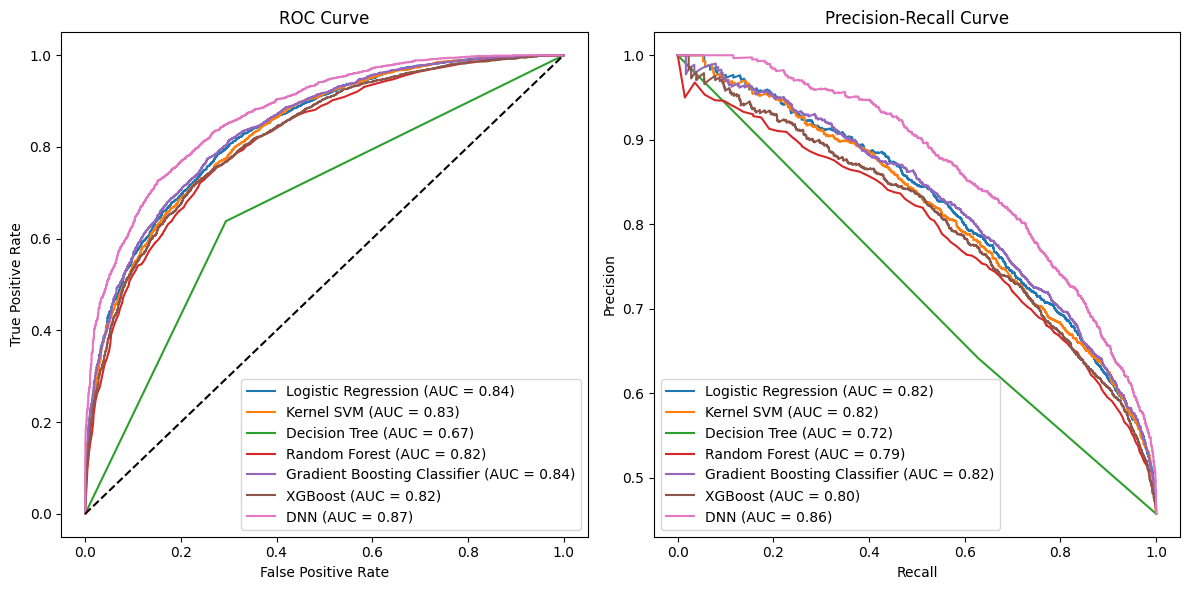

In [14]:
# Generate comparative ROC and PR curves on training data
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for model_name, model in models.items():
    if model_name != "DNN":
        y_scores = cross_val_predict(model, train_data, train_labels, cv=5, method="predict_proba")[:, 1]
        fpr, tpr, thresholds = roc_curve(train_labels, y_scores)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
    else:
        y_scores = model.predict(train_data)
        fpr, tpr, thresholds = roc_curve(train_labels, y_scores)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for model_name, model in models.items():
    if model_name != "DNN":
        y_scores = cross_val_predict(model, train_data, train_labels, cv=5, method="predict_proba")[:, 1]
        precision, recall, thresholds = precision_recall_curve(train_labels, y_scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")
    else:
        y_scores = model.predict(train_data)
        precision, recall, thresholds = precision_recall_curve(train_labels, y_scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

44/44 [==============================] - 0s 2ms/step


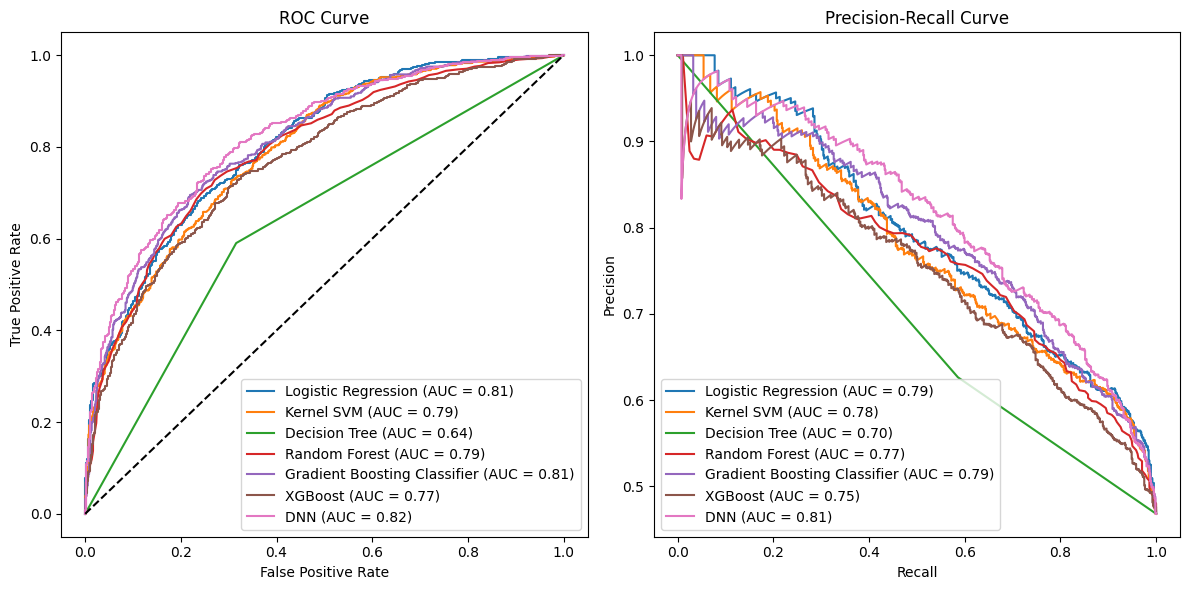

In [15]:
# Generate comparative ROC and PR curves on test data
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for model_name, model in models.items():
    if model_name != "DNN":
        y_scores = cross_val_predict(model, test_data, test_labels, cv=5, method="predict_proba")[:, 1]
        fpr, tpr, thresholds = roc_curve(test_labels, y_scores)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
    else:
        y_scores = model.predict(test_data)
        fpr, tpr, thresholds = roc_curve(test_labels, y_scores)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for model_name, model in models.items():
    if model_name != "DNN":
        y_scores = cross_val_predict(model, test_data, test_labels, cv=5, method="predict_proba")[:, 1]
        precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")
    else:
        y_scores = model.predict(test_data)
        precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()